## Does a dataset trained on Amharic perform better than regular XLMR?


We're just looking for performance better than 68% so maybe adding more languages in encourages some transfer learning. Let's add the other languages in and see if there's performance improvements.

In [3]:
# Import tfds and tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd

Are we going to use the Accelerate framework?

In [1]:
USING_ACCELERATE = False

In [2]:
import torch

if( USING_ACCELERATE):
    from accelerate import Accelerator
    accelerator = Accelerator()

### 1.1. Load Bengali Data

The Bengali dataset is different than the OLID in that it has only offensive language and targets, which are:

0: Personal Hate

1: Political Hate

2: Religious Hate

3: Geopoitical Hate

4: Gender abusive hate

In [4]:
#load our tuned Amharic dataset
bengali_data = pd.read_csv('data/Bengali/bengali_hate_v2.0.csv')
bengali_train, bengali_test = train_test_split(bengali_data)

In [5]:
bengali_train.head()

,text,label,target
378,রানুকে বাদ দিয়ে অন্য ভিডিও করুন,Personal,0
4450,মালু খানকির পোলাদের জবাই করা উচিত।,Personal,0
5421,এই তোমাদের রেট কত? তোমরা কি দুজনে একসাথে আসবা?,Personal,0
3505,জায়গা টা কোথায় ? রেট অনেক কম আর মাল গুলোও সলিট,Personal,0
721,ওর নাম নিতেও ঘৃণা লাগছে ওকে ঘুরে ভিখারী বানিয়ে...,Personal,0


In [6]:
MODEL_TYPE = 'xlm-roberta-base'


L_RATE = 0.000005 #1e-5 # need to change this potentially
MAX_LEN = 256

NUM_EPOCHS = 3
BATCH_SIZE = 32


In [7]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

# xlm-roberta-large
print('Loading XLMRoberta tokenizer...')
tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_TYPE)
print('Tokenizer loaded')

Loading XLMRoberta tokenizer...
Tokenizer loaded


In [8]:
import torch

MAX_LEN = 256 # This value could be set as 256, 512 etc.

def create_tensors( all_training_sets ):
    
    _all_labels = []
    _all_input_ids = []
    _all_attn_masks = []
    
    for t_set in all_training_sets:
        new_ids, new_masks, new_labels = tokenize_dataset(t_set)
        _all_input_ids = [*_all_input_ids, *new_ids]
        _all_attn_masks = [*_all_attn_masks, *new_masks]
        _all_labels = [*_all_labels, *new_labels]
        
    # Convert each Python list of Tensors into a 2D Tensor matrix.
    _all_input_ids = torch.cat(_all_input_ids, dim=0)
    _all_attn_masks = torch.cat(_all_attn_masks, dim=0)

    # Cast the labels list to a Tensor.
    _all_labels_tensor = torch.tensor(_all_labels)
    
    return _all_input_ids, _all_attn_masks, _all_labels_tensor, _all_labels

def tokenize_dataset( training_set ):
    
    _labels = []
    _ids = []
    _masks = []
    
    # look through all records
    for index, row in training_set.iterrows():
        encoded_dict = tokenizer.encode_plus(
                    row['text'], # Sentence to encode.
                    add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                    max_length = MAX_LEN,           # Pad or truncate.
                    pad_to_max_length = True,
                    return_attention_mask = True,   # Construct attn. masks.
                    return_tensors = 'pt',          # Return pytorch tensors.
                   )

        # Add this example to our lists.
        _ids.append(encoded_dict['input_ids'])
        _masks.append(encoded_dict['attention_mask'])
        _labels.append(row['target'])
    
    return _ids, _masks, _labels

datasets = [bengali_train]
all_input_ids, all_attn_masks, all_labels_tensor, all_labels = create_tensors(datasets)


print('   DONE. {:,} examples.'.format(len(all_labels)))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/joshnoble/.local/share/virtualenvs/joshnoble-TX97Gyyd/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2105: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   DONE. 4,273 examples.


In [9]:
datasets = [bengali_test]
test_input_ids_bengali, test_attn_masks_bengali, test_labels_bengali_tensor, test_labels_bengali = create_tensors(datasets)

print('   DONE. {:,} examples.'.format(len(test_labels_bengali)))

   DONE. 1,425 examples.


In [11]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Specify our batch size.
batch_size = 8 #also can be 16 but we're running out of memory?

# Construct a TensorDataset from the encoded examples.
prediction_dataset = TensorDataset(test_input_ids_bengali, test_attn_masks_bengali, test_labels_bengali_tensor)

# And a dataloader for handling batching.
prediction_dataloader = DataLoader(prediction_dataset, batch_size=batch_size)

In [12]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(all_input_ids, all_attn_masks, all_labels_tensor)

# Create a 90-10 train-validation split. Calculate the number of samples to 
# include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


# Specify our batch size.
batch_size = 16

# Create the DataLoaders for our training sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )




## Some Helper Functions

* **format_time** - Converts floating point seconds into hh:mm:ss
* **good_update_interval** - For printing updates, this will choose an interval.
* **check_gpu_mem** - Reports how much of the GPU's memory we're using.

Helper function for formatting elapsed times.

In [13]:
import time
import datetime

def format_time(elapsed):

    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Helper function to automatically pick a reasonable interval for printing out a progress update during training.

In [14]:
def good_update_interval(total_iters, num_desired_updates):

    exact_interval = total_iters / num_desired_updates
    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller. 
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

## Get the model

In [15]:
def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                        " GPU" if obj.is_cuda else "",
                                        " pinned" if obj.is_pinned else "",
                                        pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                    type(obj.data).__name__, 
                                                    " GPU" if obj.is_cuda else "",
                                                    " pinned" if obj.data.is_pinned else "",
                                                    " grad" if obj.requires_grad else "", 
                                                    " volatile" if obj.volatile else "",
                                                    pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)

In [16]:
torch.cuda.empty_cache()
dump_tensors()

/home/joshnoble/.local/share/virtualenvs/joshnoble-TX97Gyyd/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:151: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


Total size: 0


In [17]:
import gc

if 'xlmr_model' in globals():
    del xlmr_model
    gc.collect()
    torch.cuda.empty_cache()

We'll load the 'large' model. We could also use the base model (or any other version) but this one should be good to start.

In [18]:

from transformers import AdamW

# we're going 2 labels: offensive and not
xlmr_model = XLMRobertaForSequenceClassification.from_pretrained(MODEL_TYPE, num_labels=5)

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(xlmr_model.parameters(),
                  lr = 5e-6, #5e-6, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

if(USING_ACCELERATE):

    xlmr_model, optimizer = accelerator.prepare(xlmr_model, optimizer)
    device = accelerator.device
    
else:

    print('Loading model to GPU...')

    # Connect to the GPU.
    device = torch.device('cuda')

    # Report what GPU we were granted.
    print('  GPU:', torch.cuda.get_device_name(0))

    # Copy the initial model weights to the GPU.
    desc = xlmr_model.to(device)

    print('    DONE.')

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Loading model to GPU...
  GPU: Tesla K80
    DONE.


In [19]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    xlmr_model.train()

    # Pick an interval on which to print progress updates.
    update_interval = good_update_interval(
                total_iters = len(train_dataloader), 
                num_desired_updates = 10
            )

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update.
        if (step % update_interval) == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        #
        # Even though this is a two sentence task, XLM-R does not appear to
        # require an explicit "Segment ID" mask.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        xlmr_model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This call returns the loss (because we provided labels) and the 
        # "logits"--the model outputs prior to activation.
        loss, logits = xlmr_model.forward(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels, return_dict=False)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        if(USING_ACCELERATE):
            accelerator.backward(loss)
        else:
            loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(xlmr_model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
 
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    xlmr_model.eval()

    # Tracking variables 
    total_eval_loss = 0


    predictions, true_labels = [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = xlmr_model.forward(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels, return_dict=False)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Calculate the accuracy for this batch of test sentences.

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Measure validation accuracy...

    # Combine the results across all batches. 
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # For each sample, pick the label (0, 1, or 2) with the highest score.
    predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

    # Calculate the validation accuracy.
    val_accuracy = (predicted_labels == flat_true_labels).mean()

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    20  of    241.    Elapsed: 0:00:27.
  Batch    40  of    241.    Elapsed: 0:00:54.
  Batch    60  of    241.    Elapsed: 0:01:21.
  Batch    80  of    241.    Elapsed: 0:01:48.
  Batch   100  of    241.    Elapsed: 0:02:16.
  Batch   120  of    241.    Elapsed: 0:02:43.
  Batch   140  of    241.    Elapsed: 0:03:10.
  Batch   160  of    241.    Elapsed: 0:03:38.
  Batch   180  of    241.    Elapsed: 0:04:05.
  Batch   200  of    241.    Elapsed: 0:04:33.
  Batch   220  of    241.    Elapsed: 0:05:00.
  Batch   240  of    241.    Elapsed: 0:05:28.

  Average training loss: 1.20
  Training epcoh took: 0:05:29

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.79
  Validation took: 0:00:12

======== Epoch 2 / 3 ========
Training...
  Batch    20  of    241.    Elapsed: 0:00:28.
  Batch    40  of    241.    Elapsed: 0:00:55.
  Batch    60  of    241.    Elapsed: 0:01:23.
  Batch    80  of    241.    Elapsed: 0:01:51.
  Batch  

Let's view the summary of the training process.

First we'll put the statistics into a pandas DataFrame.

In [20]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.20,0.79,0.75,0:05:29,0:00:12
2,0.79,0.67,0.76,0:05:32,0:00:12
3,0.66,0.66,0.78,0:05:32,0:00:12


Now let's plot the 'learning curve'.

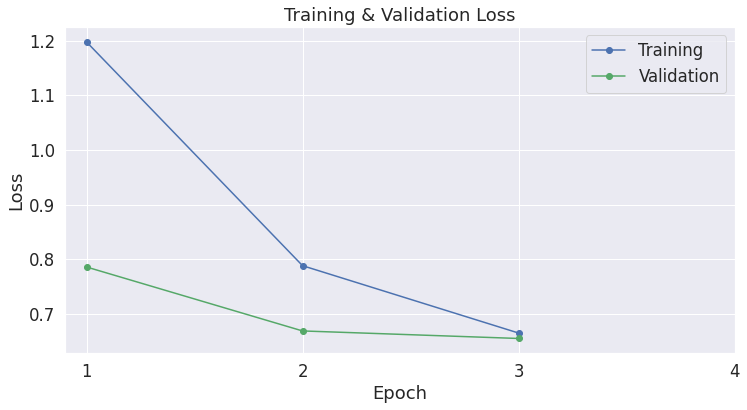

In [21]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## 4.2. Run Prediction

Run all of our Bengali test samples through our model to get predictions!

In [23]:
# Prediction on test set
print('Predicting labels for {:,} test examples...'.format(len(test_labels_bengali)))

# Put model in evaluation mode
xlmr_model.eval()

# Tracking variables 
predictions , true_labels = [], []

count = 0

# Predict 
for batch in prediction_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = xlmr_model(b_input_ids, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,425 test examples...
    DONE.


To turn our model outputs into actual predictions, we need to:

1. Re-combine the predictions from across all of the batches.
2. Pick a class label for each prediction by choosing the class with the highest output value.

In [24]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# For each sample, pick the label (0, 1) with the highest score.
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

Now we can measure our accuracy...

In [25]:
# Tally the number of correct predictions to get our accuracy.
accuracy = (predicted_labels == flat_true_labels).mean()

print('XLM-R Prediction accuracy for bengali: {:.3f}'.format(accuracy))

XLM-R Prediction accuracy for bengali: 0.808


With a learning rate of 5e-6: 0.666

In [21]:

# Now clean up afterwards:
del dataset
del prediction_dataset
del xlmr_model
torch.cuda.empty_cache()

NameError: name 'xlmr_model' is not defined